<a href="https://colab.research.google.com/github/srilamaiti/SM_MIDS_W207_HW/blob/main/10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10

#### ``Objectives``
1. Implement a CNN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques
3. Tune hyperparameters of the CNN model

#### ``Motivation``

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people.

#### ``Data``

In this assignment you will use a small dataset of retina images (`Download` links: [images](https://drive.google.com/drive/folders/1sdfUC64Un1iwuiHEehcbijxB54OhU_nd?usp=sharing) and [labels](https://drive.google.com/drive/folders/1MOlSJBZg7L1HtG5vHPt77ighRvQaGfDg?usp=sharing)). You will **build** and **train** a **CNN model** to predict whether or not to refer a patient for DR treatment using binarized severity of DR in patients: no referral if {No DR, mild} and referral if {moderate, severe, and proliferate DR}.


<u>Note</u>: the original dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/c/aptos2019-blindness-detection/).

Import the necessary libraries and make sure to replace IMAGE_PATH and LABEL_PATH with the path to the directories where you saved the data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers

# plots
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
IMAGE_PATH = '/content/drive/MyDrive/CNN_images/' # replace with your path
LABEL_PATH = os.getcwd() + "/"# replace with your path

In [3]:
count = 0
for root_dir, cur_dir, files in os.walk(IMAGE_PATH):
    print(files)
    count += len(files)
print('file count:', count)

['000c1434d8d7.png', '0024cdab0c1e.png', '00a8624548a9.png', '0083ee8054ee.png', '0124dffecf29.png', '012a242ac6ff.png', '00cc2b75cddd.png', '00b74780d31d.png', '014508ccb9cb.png', '01d9477b1171.png', '01c7808d901d.png', '0180bfa26c0b.png', '0161338f53cc.png', '0182152c50de.png', '0243404e8a00.png', '0232dfea7547.png', '0212dd31f623.png', '032d7b0b4bf6.png', '03a7f4a5786f.png', '03676c71ed1b.png', '03747397839f.png', '03c85870824c.png', '03ff7d159f10.png', '03fd50da928d.png', '03e25101e8e8.png', '04a6fc58dabc.png', '050bb1eafa76.png', '041f09eec1e8.png', '04579e31e4be.png', '04ac765f91a1.png', '0423237770a7.png', '04d029cfb612.png', '052d9a3fe55a.png', '0519b934f6b1.png', '054b1b305160.png', '05339950962e.png', '0551676cc2aa.png', '064af6592ba6.png', '05a5183c92d0.png', '05e9126dfa5c.png', '05cd0178ccfe.png', '059bc89df7f4.png', '069f43616fab.png', '0684311afdfc.png', '07419eddd6be.png', '070d4ce5fd90.png', '0790515cf5af.png', '07751b94a88a.png', '070f67572d03.png', '07e827469099.png',

At this point, you may ask yourself what the best CNN model that fits this data is. First, you will want to read through the data description in Kaggle (see the link to the original dataset above). Understanding what you are working with challenges you to write preprocessing code that uncovers your data's most helpful information.

---
### Exercise 1 (8 points)

Read the data description from Kaggle and list (a) the source of images and (b) the labeling procedure.

*Written answer*:

1. Data Source<br>
Retina images taken using "fundus photography" under a variety of imaging conditions by the technicians from Aravind Hospital in India who traveled to rural areas to capture the images.
2. The retina images are rated by a clinicianfor the severity of diabetic retinopathy on a scale of 0 to 4:

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

---

## Read data

Let's now explore our dataset. We will start with label inspection and continue with image visualization.

In [4]:
y = pd.read_csv(
    LABEL_PATH + 'labels.csv'
)
y.sort_values(by=['id_code'], inplace = True)
print('Shape of labels:', y.shape)
print('Unique diagnosis codes:', np.sort(y.diagnosis.unique()))
y.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


,id_code,diagnosis
0,000c1434d8d7,2
1,0024cdab0c1e,1
2,0083ee8054ee,4
3,00a8624548a9,2
4,00b74780d31d,2


There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes: 

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)


Image inspection:

Sample of images in data:


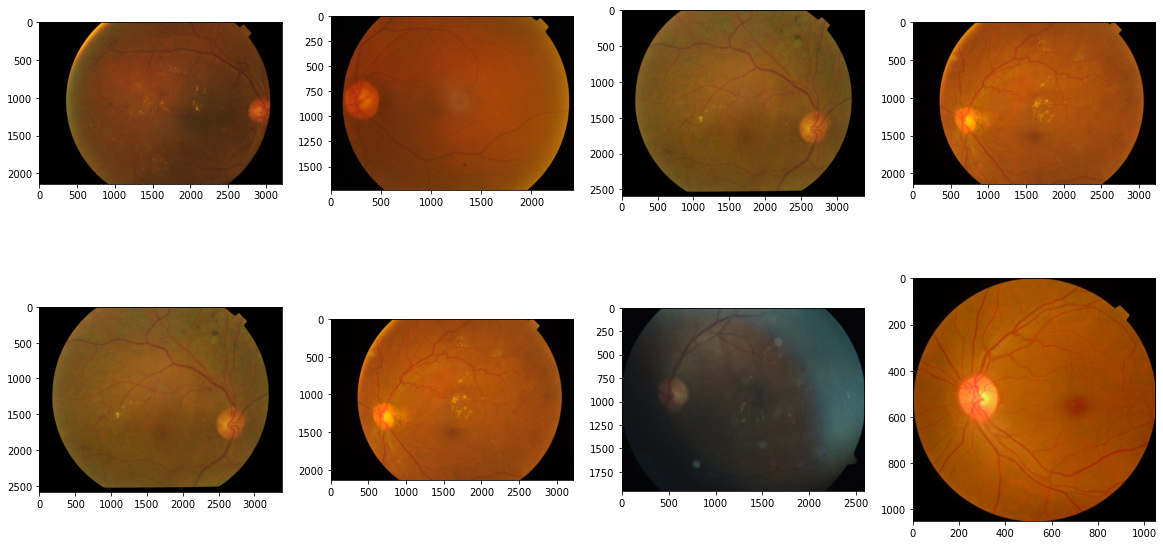

In [5]:
# read image
indx=0
images = []

print('Sample of images in data:')
for idx, img in enumerate(sorted(os.listdir(IMAGE_PATH))):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

nrows, ncols = 2,4 #print first 8 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = i*nrows+j
        axs[i,j].imshow(images[indx])

Like any real-world data set, you can see that these images have different sizes and focus. Later, you will use image transformation and data augmentation techniques to remove some of this variation.

## Data preprocessing

The quality of the data determines how well a machine learning algorithm can learn. This section will apply some simple techniques to deal with class imbalance. We will then create training/validation/test datasets and perform image transformation and augmentation.

---
### Exercise 2 (8 points)

Graph a histogram for the five classes of DR. Write down the percentage of the largest class in the written answer below. 

In [6]:
from tables import conditions
df_value_counts = pd.DataFrame(y['diagnosis'].value_counts()).reset_index()
df_value_counts.columns = ['diagnosis', 'count']
mapping_dict = {0: "No DR", 1 : "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate DR"}
df_value_counts['diagnosis_label'] = df_value_counts['diagnosis'].map(mapping_dict)
df_value_counts['total_records'] = len(y)
df_value_counts['cnt_pct'] = 100 * (df_value_counts['count'] / df_value_counts['total_records'])
df_value_counts['cnt_pct'] = df_value_counts['cnt_pct'].apply(lambda x: str(x) + '%')
df_value_counts[['diagnosis', 'diagnosis_label', 'cnt_pct']]

,diagnosis,diagnosis_label,cnt_pct
0,0,No DR,41.0%
1,2,Moderate,36.5%
2,1,Mild,9.0%
3,4,Proliferate DR,7.5%
4,3,Severe,6.0%


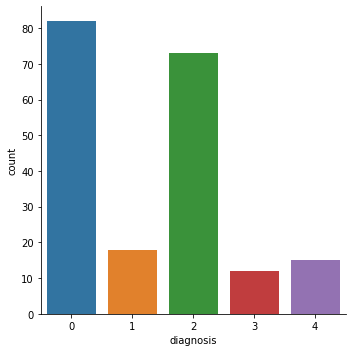

In [7]:
# YOUR CODE HERE
sns.catplot(data=y, x="diagnosis", kind="count")

*Written answer*:

diagnosis|diagnosis_label|cnt_pct
-|-|-
0|No DR	|41.0%
2|Moderate|	36.5%
1|Mild|	9.0%
4|Proliferate DR|	7.5%
3|Severe|	6.0%

---

`Correct for data imbalance`

As you can see from the histogram above, our dataset is very imbalanced, which is common in healthcare, and it happens because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We will correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}


  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

It is a crude method to deal with imbalanced data, but it will be good enough for this homework. 

In [8]:
np.random.seed(1234)

no_refer = y[y.diagnosis.isin((0,1))]
refer = y[y.diagnosis.isin((2,3,4))]

# randomly draw 80 images from each classes
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))

Next, we will use the **preprocess_data_part1()** function defined below to generate lists of images and labels (`images_mini` and `y_mini`) based on the values in the temp_no_refer and temp_refer lists.

In [9]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    y_mini = []
    images_mini = []

    # create lists of images and labels `images_mini` and `y_mini` 
    # based on temp_no_refer and temp_refer selections
    for idx, img in enumerate(sorted(os.listdir(IMAGE_PATH))):
        # read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue

        
        # read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )
        
        # transform image to array
        img = img_to_array(img)

        # append to images
        images_mini.append(img)

    # stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten() 
    
    return images_mini, y_mini

In [10]:
# generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(IMAGE_PATH, LABEL_PATH)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (160, 224, 224, 3)
y_mini shape (160,)


`Create train/validation/test data` and ``perform image tranformation and augmentation``

The next step in the data preprocessing part is to split the data into training, validation, and test sets. Once we have these partitions, we will apply image transformation and augmentations.


To give you an idea of what image transformation and augmentation do, let's see an example applied to the first image in our mini data.

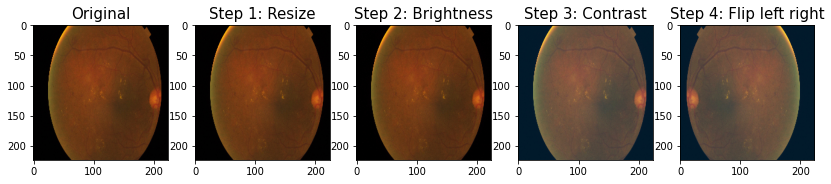

In [11]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(224, 224))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);


# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

Next, we will define and run the **preprocess_data_part2()** function to create:

* train/validation/test sets with split (0.6,0.2,0.2)

* image transformation and augmentation, as follows:

<u>Applied on training, validation and test sets</u>:
  - resize to IMAGE_SIZE =(224,224) using tf.image.resize()
  - normalize all pixel values to the range (0,1)
  
<u>Applied on training set only</u> (note that this step will create additional/augmented copies of the training data):
  - adjust brightness by adding DELTA=0.3 to the pixel values using tf.image.adjust_brighness()
  - adjust contrast to CONTRAST_FACTOR=3 using tf.image.adjust_contrast()
  - flip left right using tf.image.flip_left_right()

The quantity and diversity of data gathered have a significant impact on the results of a CNN model. One can apply augmentations to artificially inflate the training dataset by warping the original data such that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [12]:
IMAGE_SIZE = (224, 224)
CONTRAST_FACTOR = 3
DELTA = 0.3

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images_mini, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_mini, [splits[0], splits[0]+splits[1]])
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's sanity check our implementation of the preprocess_data_part2() function by printing the shape of (X,y) from train, validation and test sets.

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (192, 224, 224, 3)
y_train shape (192,)
X_val shape (32, 224, 224, 3)
y_val shape (32,)
X_test shape (32, 224, 224, 3)
y_test shape (32,)


Let's also print out the first 8 train and validation examples with the label of each example as the title.

Print training data examples:


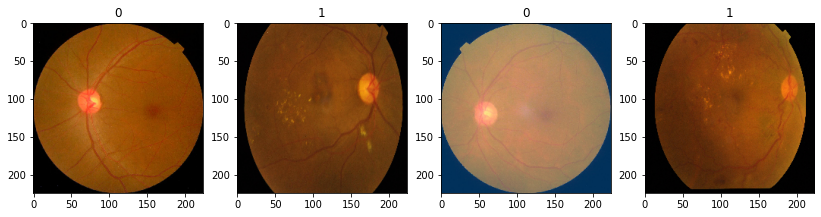

In [14]:
# print taining data
print('Print training data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])

Print validation data examples:


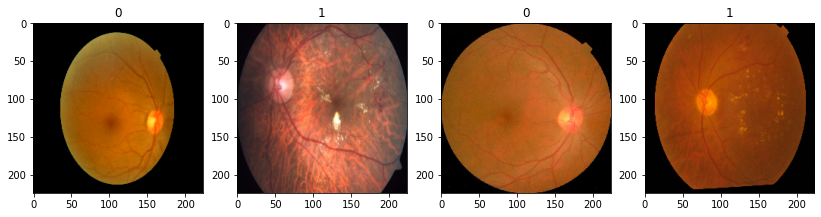

In [15]:
# print test data
print('Print validation data examples:')
nrows, ncols = 1,4 #print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_val[i]))
    axs[i].set(title=y_val[i])

---
### Exercise 3 (8 points)

We've split the data into train, validation, and test sets. Explain the purpose of each of these.


*Written answer*:

In most supervised machine learning tasks, best practice recommends to split the input data into three independent sets: a training set, a testing set, and a validation set.

Training Set: This part of the dataset is fed to the machine learning model to learn potential underlying patterns and relationships. If we apply augmentation, we apply it on the training data set only.

Validation Set: The dataset that we use to understand our model's performance across different model types and hyperparameter choices. We do not apply any tweaking on validation data set. Image augmentation techniques are not applied on the validation data set.

Test Set: The dataset that we use to approximate our model's unbiased accuracy in the wild. We use this part of the dataset to test how our model performs on the unseen data.

___

## Model

Our objective is to build and train a CNN model to refer patients to doctors based on the severity of DR seen in these images. We are interested in exploring binary classification of 'no refer' and 'refer'.

<u>The architecture of our CNN model is as follows</u>:

1. the model receives input images of size 224 x 224 x 3 (the images have three color channels)
2. the input data goes through two convolutional layers that have kernels of size 5 x 5
3. the first convolution has 32 output feature maps, and the second one has 64
4. each convolution layer is followed by a max-pooling layer (this will reduce the size of the feature maps)
5. the last two layers of the model are fully connected with a droput layer in between

For each convolution we use strides=(1,1) to preserve the dimension of the inputs in the resulting feature maps. For the pooling layers, we set strides=(2,2) to subsample the image and shrink the size of the output feature maps. For the dropout layer, we set the probability of dropping input units during training to 0.5.


We will implement this architecture using TensorFlow Keras API.

``Build model``

In [16]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
model.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation=None))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 112, 112, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 112, 64)      51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 56, 56, 64)        0         
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 fc_1 (Dense)                (None, 1024)              205521920 
                                                                 
 dropout (Dropout)           (None, 1024)              0

``Compile model``

The next step is to compile the model. We have to decide on the type of optimizer, loss function, and metrics to compute.

We will use the Adam optimizer for this assignment, the most popular gradient-based optimization algorithm. There are a few other choices, and you can read more [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers). The loss (cost) function suitable for our binary classification model is [binary_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses). We will compute model accuracy on the training, validation and test datasets.

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 

``Fit model``

Finally, we will fit the model with 10 epochs on the train set and validate on the validation set. The performance depends on the current starter hyperparameters such as learning rate and choice of optimizer.

In [18]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train,
                    epochs=10, 
                    validation_data=(X_val, y_val)
)

Epoch 1/10
6/6 [==============================] - 11s 64ms/step - loss: 6.1135 - accuracy: 0.6302 - val_loss: 0.3486 - val_accuracy: 0.7812
Epoch 2/10
6/6 [==============================] - 0s 28ms/step - loss: 0.8098 - accuracy: 0.7188 - val_loss: 0.3142 - val_accuracy: 0.7812
Epoch 3/10
6/6 [==============================] - 0s 28ms/step - loss: 0.4678 - accuracy: 0.7917 - val_loss: 0.3649 - val_accuracy: 0.6875
Epoch 4/10
6/6 [==============================] - 0s 28ms/step - loss: 0.4281 - accuracy: 0.8073 - val_loss: 0.3944 - val_accuracy: 0.6875
Epoch 5/10
6/6 [==============================] - 0s 28ms/step - loss: 0.3836 - accuracy: 0.8229 - val_loss: 0.2971 - val_accuracy: 0.6875
Epoch 6/10
6/6 [==============================] - 0s 29ms/step - loss: 0.3174 - accuracy: 0.8594 - val_loss: 0.3812 - val_accuracy: 0.6875
Epoch 7/10
6/6 [==============================] - 0s 28ms/step - loss: 0.2946 - accuracy: 0.8438 - val_loss: 0.3223 - val_accuracy: 0.7188
Epoch 8/10
6/6 [==========

Next let's plot loss and accuracy for training and validation sets

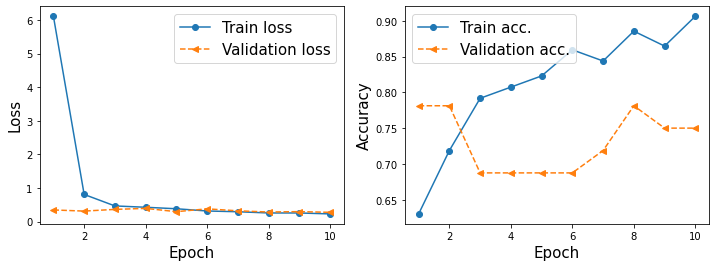

In [19]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

## Show what the CNN model is learning after each layer

We will pick one example from our training data to visualize our CNN model's learning after each layer. Below we print the original image.

Shape of image: (1, 224, 224, 3)


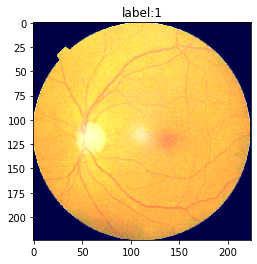

In [20]:
img_tensor = np.expand_dims(X_train[2], axis = 0);

# Print image tensor shape
print('Shape of image:', img_tensor.shape);
  
# Print image
plt.imshow(img_tensor[0]);
plt.title('label:' + str(y_train[1]))
plt.show()

Next we print what the model learns after each layer-channel. It's important to pay attention to the shape of the output image to understand what each layer does to the original input.

1/1 [==============================] - 0s 109ms/step
----------------
Geeting activations of layer 1 : conv_1
Images size is 224 x 224
Number of channels is 32
Printing channels:


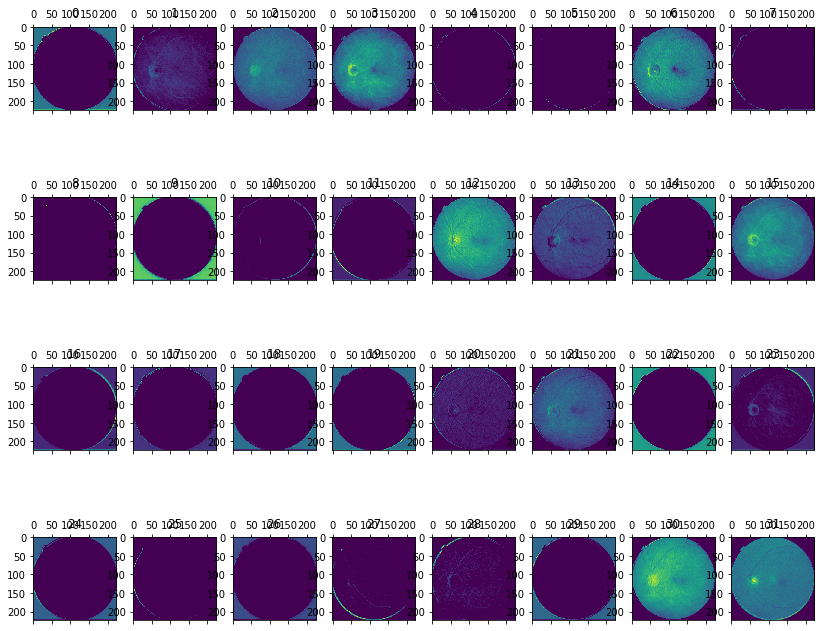

----------------
Geeting activations of layer 2 : pool_1
Images size is 112 x 112
Number of channels is 32
Printing channels:


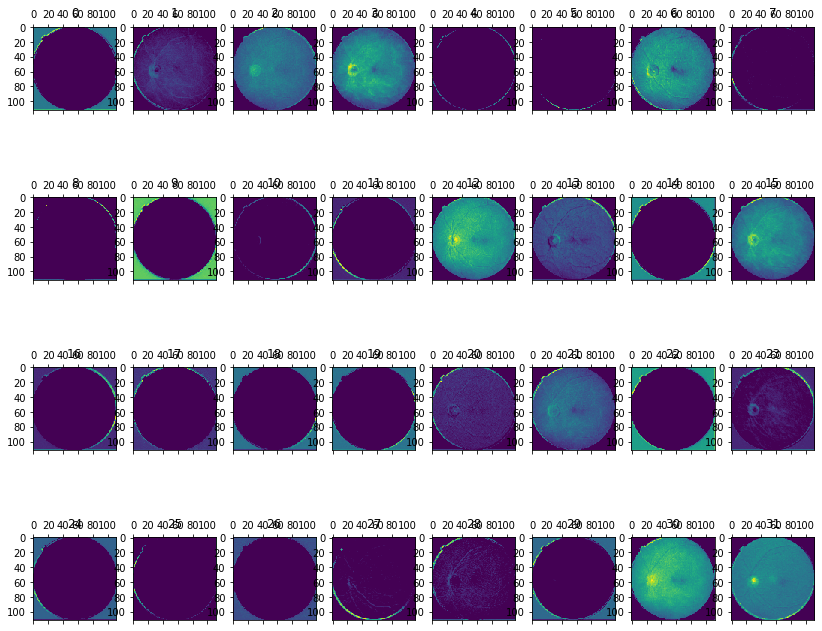

----------------
Geeting activations of layer 3 : conv_2
Images size is 112 x 112
Number of channels is 64
Printing channels:


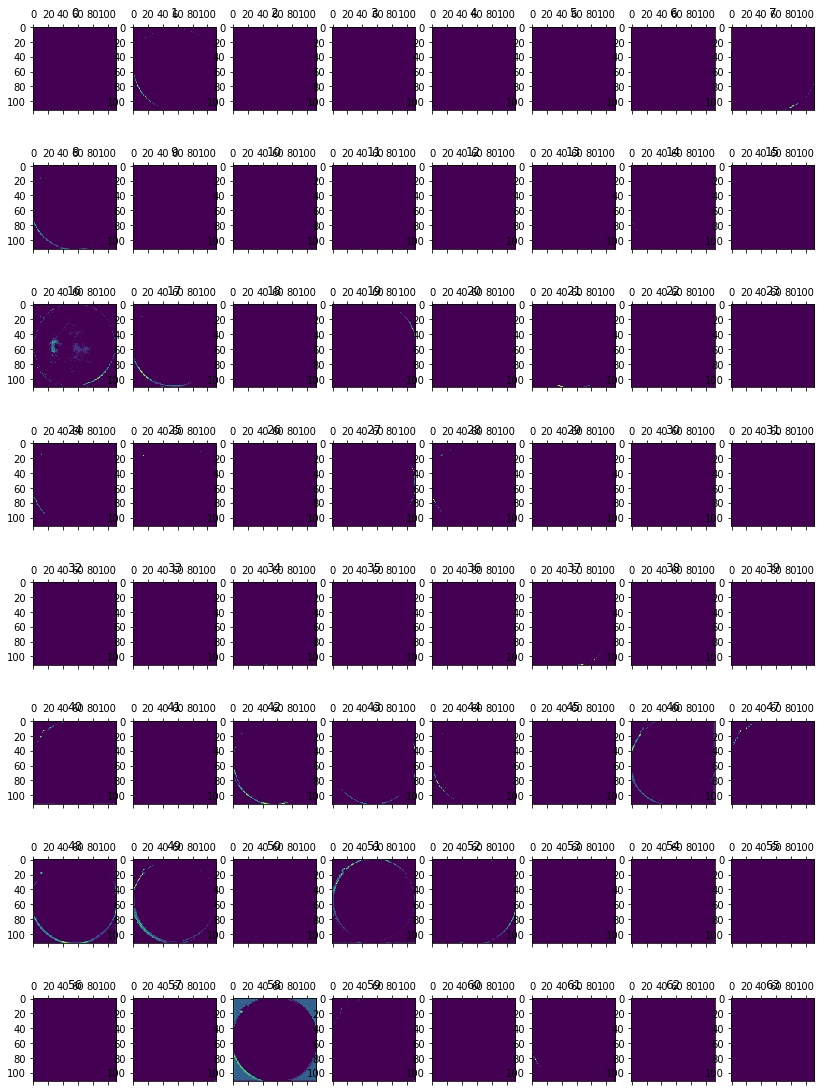

----------------
Geeting activations of layer 4 : pool_2
Images size is 56 x 56
Number of channels is 64
Printing channels:


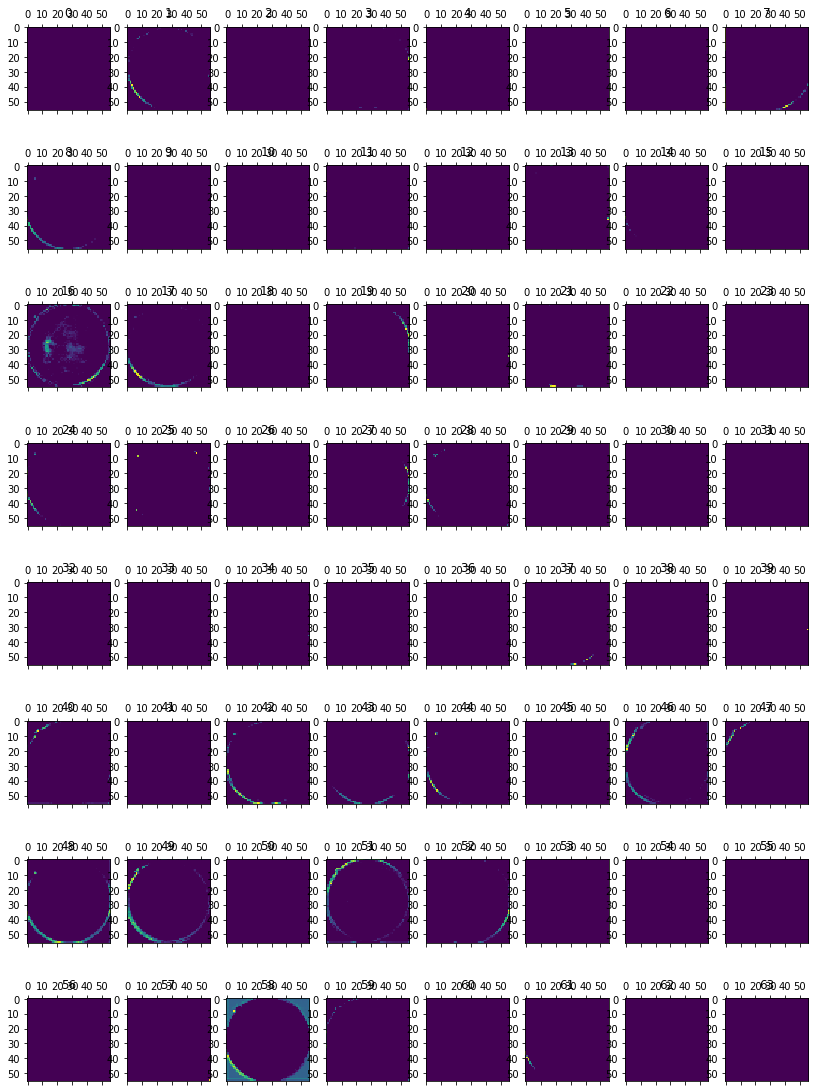

In [21]:
# outputs of the first 4 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

# grab layer names
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

# getting activations of each layer
for idx, layer in enumerate(activations):
    if idx in (0,1,2,3):
        print('----------------')
        print('Geeting activations of layer',  idx+1, ':', layer_names[idx])
        activation = layer

        # shape of layer activation
        print('Images size is', activation.shape[1], 'x', activation.shape[2])
        print('Number of channels is', activation.shape[3])

        # print channels
        print('Printing channels:')
        
        # define nrows and ncols depending on number of channels
        if idx in (0,1):
            nrows, ncols = 4,8
        if idx in (2,3):
            nrows, ncols = 8,8

        # plots
        channel=0
        if idx in (0,1):
            f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
        if idx in (2,3):
            f, axs = plt.subplots(nrows, ncols, figsize=(14,20))
            
        for i in range(nrows):
            for j in range(ncols):
                if i==0 and j==0:
                    channel=0
                else:
                    channel+=1

                axs[i,j].matshow(activation[0,:, :, channel], cmap ='viridis')
                axs[i,j].set(title=str(channel))
                #axs[i,j].axis('off') # pay attention to the range of x and y axis
        plt.show()


As you can see, initial layers are more interpretable and retain the majority of the features in the input image. As the level of the layer increases, features become less interpretable, they become more abstract and they identify features specific to the class leaving behind the general features of the image.

## Evaluation

Evaluation is one of the most important parts of machine learning as it helps us determine how good our trained model is in predicting unseen data.

Notice that (`X_test`, and `y_test`) were not used in the training part. It would be very bad practice to evaluate the model on the test set, and then return and update the model based on those results (then the test set is acting like just another validation set). 

We will now use our test data to evaluate the performance (accuracy) of our CNN model on unseen data. Note that accuracy is the default metric if one compiles the model with the accuracy metric.

In [22]:
test_results = model.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

1/1 [==============================] - 0s 31ms/step - loss: 0.3372 - accuracy: 0.8750

Test Acc. 87.50%


`get predictions results in the form of class-membership probabilities`

In the following figure, you can see all the images in the test data along with their ground truth (GT) labels and the predicted probabiliy that they belong to class 1, 'Refer' 

In [23]:
# transform logits to probabilities
pred_logits = model.predict(X_test)
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

1/1 [==============================] - 0s 67ms/step


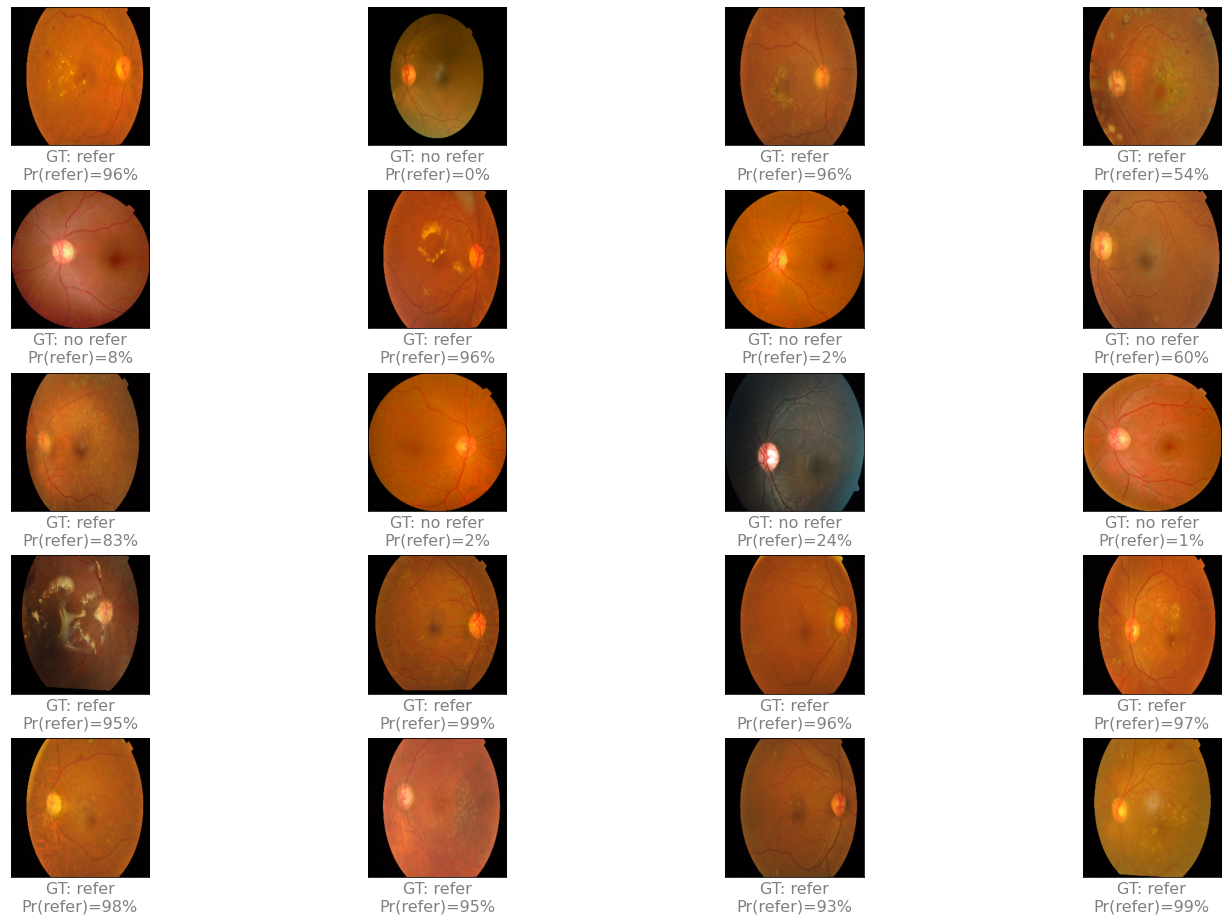

In [24]:
# plot test data and associated predicred
fig = plt.figure(figsize=(20, 20))

for j, example in enumerate(X_test[:20]):
    ax = fig.add_subplot(8,4, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(array_to_img(example))
    if y_test[j]==0:
        label='no refer'
    else:
        label='refer'
    
    ax.text(
        0.5, -0.15, 
        'GT: {:s}\nPr(refer)={:.0f}%'.format(label, probas[j]), 
        size=16, 
        color='grey',
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
plt.tight_layout()
plt.show()

---
### Exercise 4 (8 points)

In this exercise, your task is to experiment with different hyperparameter values to see how sensitive the accuracy of our CNN model is.  In the table below, you will fill in `training and validation accuracy` results corresponding to the last epoch of the model fit.

You will change one hyperparameter value at a time, as follows: 

* kernel size = 3 x 3
* strides = 2 x 2
* pool size = 3 x 3
* learning rate = 0.01
* optimizer = 'SGD'
* image augmentation applied on the training data: (brightness_delta = 0.1, contrast = 2, flip = no)

Finally, comment on the CNN model specification that you are most satisfied with based on the accuracy achieved on the training and validation sets. For this specification, what is the accuracy of the test dataset?

In [30]:
# generate images and labels based on preprocess_data_part1() function
#images_mini, y_mini = preprocess_data_part1(IMAGE_PATH, LABEL_PATH)

def parametrized_preprocess_data(images, y, split=(0.6,0.2,0.2), brightness_delta=.1, contrast_factor = 2, flip = False):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images_mini, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_mini, [splits[0], splits[0]+splits[1]])
    
    ### image transformation on training, validation, and test data ###
    ###################################################################
    # image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    # rescale image to [0,1], i.e., greyscale
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    
    ### image augmentation on training data ###
    ###########################################
    # adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=brightness_delta)
    
    # adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=contrast_factor)

    # random flip
    if flip.upper() == 'YES':
        X_train_augm = tf.image.random_flip_left_right(X_train_augm)
    
    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def build_model(X_train, 
                y_train, 
                X_val, 
                y_val, 
                X_test,
                y_test,
                kernel_size = (3,3), 
                strides = (2,2), 
                pool_size = (3,3), 
                learning_rate = 0.01, 
                optimizer_val = 'SGD',
                contrast_factor=2,
                brightness_delta=.1,
                flip_on_train='no'):
    """
    This function builds TF sequential model.
    """
    model = tf.keras.Sequential()

    # add first convolution layer to the model
    model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


    # add a max pooling layer with pool size (2,2) and strides of 2
    # (this will reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
    pool_size=pool_size,
    name='pool_1'))

    # add second convolutional layer
    model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=kernel_size,
    strides=strides,
    padding='same',
    name='conv_2',
    activation='relu'))

    # add second max pooling layer with pool size (2,2) and strides of 2
    # (this will further reduce the spatial dimensions by half)
    model.add(tf.keras.layers.MaxPool2D(
    pool_size=pool_size, name='pool_2')
    )

    # add a fully connected layer (need to flatten the output of the previous layers first)
    model.add(tf.keras.layers.Flatten()) 
    model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

    # add dropout layer
    model.add(tf.keras.layers.Dropout(
    rate=0.5))

    # add the last fully connected layer
    # this last layer sets the activation function to "None" in order to output the logits 
    # note that passing activation = "sigmoid" will return class memembership probabilities but
    # in TensorFlow logits are prefered for numerical stability
    # set units=1 to get a single output unit (remember it's a binary classification problem)
    model.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation=None))

    # build model and print summary
    tf.random.set_seed(1)
    model.build(input_shape=(None, 224, 224, 3))
    model.summary()

    if optimizer_val.upper() == 'ADAM':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_val.upper() == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    history = model.fit(X_train, y_train,
                        epochs=10, 
                        validation_data=(X_val, y_val)
                       )
    hist = history.history
    test_results = model.evaluate(X_test, y_test)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))
    #print(hist)
    #return ''
    return (np.round(hist['accuracy'][-1], 2),
            np.round(hist['val_accuracy'][-1], 2),
            np.round(test_results[1], 2),
            kernel_size, 
            strides, 
            pool_size, 
            learning_rate, 
            optimizer_val, 
            brightness_delta, 
            contrast_factor, 
            flip_on_train
           )

param_dict = {'exec_1': {'kernel_size':	(5,5), 
                         'strides':	(1,1),
                         'pool_size':	(2,2),
                         'learning_rate':	0.001,
                         'optimizer': 'Adam',	
                         'brightness_delta':	.3,
                         'contrast_factor':	3,
                         'flip_on_train': 'Yes'
                        },
              'exec_2' : {'kernel_size':  (3,3), 
                          'strides':  (1,1),
                          'pool_size':  (2,2),
                          'learning_rate':  0.001,
                          'optimizer': 'Adam',  
                          'brightness_delta': .3,
                          'contrast_factor':  3,
                          'flip_on_train': 'Yes'
                         },
              'exec_3' : {'kernel_size':  (5,5), 
                          'strides':  (2,2),
                          'pool_size':  (2,2),
                          'learning_rate':  0.001,
                          'optimizer': 'Adam',  
                          'brightness_delta': .3,
                          'contrast_factor':  3,
                          'flip_on_train': 'Yes'
                         },
              'exec_4' : {'kernel_size':  (5,5), 
                          'strides':  (1,1),
                          'pool_size':  (3,3),
                          'learning_rate':  0.001,
                          'optimizer': 'Adam',  
                          'brightness_delta': .3,
                          'contrast_factor':  3,
                          'flip_on_train': 'Yes'
                         },
              'exec_5' : {'kernel_size':  (5,5), 
                          'strides':  (1,1),
                          'pool_size':  (2,2),
                          'learning_rate':  0.01,
                          'optimizer': 'Adam',  
                          'brightness_delta': .3,
                          'contrast_factor':  3,
                          'flip_on_train': 'Yes'
                         },
              'exec_6' : {'kernel_size':  (5,5), 
                          'strides':  (1,1),
                          'pool_size':  (2,2),
                          'learning_rate':  0.001,
                          'optimizer': 'SGD', 
                          'brightness_delta': .3,
                          'contrast_factor':  3,
                          'flip_on_train': 'Yes'
                         },
              'exec_7' : {'kernel_size':  (5,5), 
                          'strides':  (1,1),
                          'pool_size':  (2,2),
                          'learning_rate':  0.001,
                          'optimizer': 'Adam',  
                          'brightness_delta': .1,
                          'contrast_factor':  3,
                          'flip_on_train': 'Yes'
                         },
              'exec_8' : {'kernel_size':  (5,5), 
                          'strides':  (1,1),
                          'pool_size':  (2,2),
                          'learning_rate':  0.001,
                          'optimizer': 'Adam',  
                          'brightness_delta': .3,
                          'contrast_factor':  2,
                          'flip_on_train': 'Yes'
                         },
              'exec_9' : {'kernel_size':  (5,5), 
                          'strides':  (1,1),
                          'pool_size':  (2,2),
                          'learning_rate':  0.001,
                          'optimizer': 'Adam',  
                          'brightness_delta': .3,
                          'contrast_factor':  3,
                          'flip_on_train': 'no'
                         }
              }
grid_search_output = []
for key in param_dict.keys():
    param_val = param_dict[key]
    images_mini, y_mini = preprocess_data_part1(IMAGE_PATH, LABEL_PATH)
    X_train, y_train, X_val, y_val, X_test, y_test = parametrized_preprocess_data(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2),
    brightness_delta=param_val['brightness_delta'],
    contrast_factor=param_val['contrast_factor'],
    flip=param_val['flip_on_train']
    )
    print(key)
    '''
    print(f"X_train shape {X_train.shape}")
    print(f"y_train shape {y_train.shape}")
    print(f"X_val shape {X_val.shape}")
    print(f"y_val shape {y_val.shape}")
    print(f"X_test shape {X_test.shape}")
    print(f"y_test shape {y_test.shape}")
    '''
    model_output = build_model(X_train, 
                               y_train, 
                               X_val, 
                               y_val, 
                               X_test,
                               y_test,
                               kernel_size = param_val['kernel_size'], 
                               strides = param_val['strides'], 
                               pool_size = param_val['pool_size'],
                               learning_rate = param_val['learning_rate'],
                               optimizer_val = param_val['optimizer'],
                               brightness_delta = param_val['brightness_delta'],
                               contrast_factor = param_val['contrast_factor'],
                               flip_on_train = param_val['flip_on_train']
                               )
    grid_search_output.append(model_output)
    #grid_search_output.append('-|-|-|-|-|-|-|-|-|-') 
    tf.keras.backend.clear_session()
    print("***********")

exec_1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 112, 112, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 112, 64)      51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 56, 56, 64)        0         
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 fc_1 (Dense)                (None, 1024)              205521920 
                                                                 
 dropout (Dropout)           (None, 1024)        

In [31]:
op_list = []
op_list.append('training_accuracy|validation_accuracy|test_accuracy|kernel_size|strides|pool_size|learning_rate|optimizer|brightness_delta|contrast_factor|flip_on_train')
op_list.append('-|-|-|-|-|-|-|-|-|-|-')
for e in grid_search_output:
    op_str = ''
    for e1 in e:
        op_str = op_str + str(e1) + "|"
    op_list.append(op_str[:-1])

In [32]:
str(op_list).replace("'","")

'[trining_accuracy|validation_accuracy|test_accuracy|kernel_size|strides|pool_size|learning_rate|optimizer|brightness_delta|contrast_factor|flip_on_train, -|-|-|-|-|-|-|-|-|-|-, 0.89|0.78|0.91|(5, 5)|(1, 1)|(2, 2)|0.001|Adam|0.3|3|Yes, 0.96|0.72|0.91|(3, 3)|(1, 1)|(2, 2)|0.001|Adam|0.3|3|Yes, 0.89|0.69|0.91|(5, 5)|(2, 2)|(2, 2)|0.001|Adam|0.3|3|Yes, 0.88|0.75|0.88|(5, 5)|(1, 1)|(3, 3)|0.001|Adam|0.3|3|Yes, 0.81|0.75|0.88|(5, 5)|(1, 1)|(2, 2)|0.01|Adam|0.3|3|Yes, 0.62|0.47|0.47|(5, 5)|(1, 1)|(2, 2)|0.001|SGD|0.3|3|Yes, 0.89|0.88|0.84|(5, 5)|(1, 1)|(2, 2)|0.001|Adam|0.1|3|Yes, 0.87|0.75|0.88|(5, 5)|(1, 1)|(2, 2)|0.001|Adam|0.3|2|Yes, 0.91|0.69|0.88|(5, 5)|(1, 1)|(2, 2)|0.001|Adam|0.3|3|no]'

trining_accuracy|validation_accuracy|test_accuracy|kernel_size|strides|pool_size|learning_rate|optimizer|brightness_delta|contrast_factor|flip_on_train 
-|-|-|-|-|-|-|-|-|-|-
0.89|0.78|0.91|(5, 5)|(1, 1)|(2, 2)|0.001|Adam|0.3|3|Yes 
0.96|0.72|0.91|(3, 3)|(1, 1)|(2, 2)|0.001|Adam|0.3|3|Yes 
0.89|0.69|0.91|(5, 5)|(2, 2)|(2, 2)|0.001|Adam|0.3|3|Yes 
0.88|0.75|0.88|(5, 5)|(1, 1)|(3, 3)|0.001|Adam|0.3|3|Yes
0.81|0.75|0.88|(5, 5)|(1, 1)|(2, 2)|0.01|Adam|0.3|3|Yes 
0.62|0.47|0.47|(5, 5)|(1, 1)|(2, 2)|0.001|SGD|0.3|3|Yes 
0.89|0.88|0.84|(5, 5)|(1, 1)|(2, 2)|0.001|Adam|0.1|3|Yes
0.87|0.75|0.88|(5, 5)|(1, 1)|(2, 2)|0.001|Adam|0.3|2|Yes 
0.91|0.69|0.88|(5, 5)|(1, 1)|(2, 2)|0.001|Adam|0.3|3|no


*Written answer*:

| training_accuracy | validation_accuracy |  kernel_size |  strides | pool_size  |  learning_rate | optimizer  | brightness_delta |  contrast_factor | flip_on_train  |
|:-:                |:-:                  |:-:           |:-:       |:-:         |:-:             |:-:         |:-:                 |:-:               |:-:             |
| 0.94              | 0.81                | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | 0.3                | 3                | yes            |
| ...               | ...                 | <font color="red">3,3</font>     | 1,1      | 2,2        | 0.001          | Adam       | 0.3                | 3                | yes            |
| ...               | ...                 | 5,5          | <font color="red">2,2</font>  | 2,2        | 0.001          | Adam       | 0.3                | 3                | yes            |
| ...               | ...                 | 5,5          | 1,1      | <font color="red">3,3</font>   | 0.001          | Adam       | 0.3                | 3                | yes            |
| ...               | ...                 | 5,5          | 1,1      | 2,2        | <font color="red">0.01</font>       | Adam       | 0.3                | 3                | yes            |
| ...               | ...                 | 5,5          | 1,1      | 2,2        | 0.001          |<font color="red">SGD</font>     | 0.3                | 3                | yes            |
| ...               | ...                 | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | <font color="red">0.1</font>            | 3                | yes            |
| ...               | ...                 | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | 0.3                | <font color="red">2</font>            | yes            |
| ...               | ...                 | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | 0.3                | 3                | <font color="red">no</font>         |

---